In [1]:
import numpy as np
import qutip
from qze.dimer import DimerParameters, get_c_ops, get_H_S
from qze.dimer_gutz_mc import DimerGutzMCParameters
import matplotlib.pyplot as plt

In [2]:
lambdas = [[.25, .25],
           [.25, 1.75],
           [1.25, .25]]

bins = 72
binning_range = [[-np.pi, np.pi], [-np.pi, np.pi]]

bins_lr = 36

In [3]:
# Number of simulations with the same parameters.
Nsim = 5

# Simulation parameters.
nwalk = int(2 * 10**7)

# lambdas = [[.25, .25],
#            [.25, 1.75],
#            [1.25, .25]]

T = 20
dt = .01
omega_S = 1
walk_pos0 = np.array(nwalk * [[np.pi, np.pi]])
# walk_pos0 = None


# Data loading
hist_gutz = []
hist_gutz_lr = []

for (lmbd_1, lmbd_2) in lambdas:
    walk_pos = []
    for simid in range(Nsim):
        sim = DimerGutzMCParameters(omega_S,
                                    lmbd_1,
                                    lmbd_2,
                                    walk_pos0,
                                    dt,
                                    T,
                                    nwalk,
                                    simid)
        # f = open(f"data/{str(sim)}.pkl", "rb")
        # data = load(f)
        # f.close()
        # walk_pos.append(data[1])
        f = open(f"data/{str(sim)}.npz", "rb")
        data = np.load(f)
        walk_pos.append(data['walk_pos'])

    walk_pos = np.array(walk_pos)
    walk_pos = np.concatenate(walk_pos, axis=0)    

    h, edges_l, edges_r = np.histogram2d(walk_pos[:, 0],
                                         walk_pos[:, 1],
                                         bins=bins,
                                         range=binning_range,
                                         density=True)
    
    h_lr, edges_l_lr, edges_r_lr = np.histogram2d(walk_pos[:, 0],
                                                  walk_pos[:, 1],
                                                  bins=bins_lr,
                                                  range=binning_range,
                                                  density=True)
    
    hist_gutz.append(h)
    hist_gutz_lr.append(h_lr)

In [4]:
# Number of simulations with the same parameters.
nsim = 4

# Statistics
ntraj = int(2.5 * 10**5)

# Physical parameters.
# lambdas = [[.25, 1.75]]
# lambdas = [[.25, .25],
#            [.25, 1.75],
#            [1.25, .25]]

T = 20
dt = .01
omega_S = 1

t_eval = np.array([0, T])

# solver = "trsolve"
solver = "mcsolve"
# solver = "gutzwiller"

store_states = False
compute_eentropy = False
compute_fidelity = False

no_click = False

psi0 = qutip.tensor(qutip.basis(2, 1), qutip.basis(2, 1))


# Data loading
hist_full = []
hist_full_lr = []


for i, (lmbd_1, lmbd_2) in enumerate(lambdas):
    tl = []
    tr = []

    # Sketcy solution to make up for inhomogeneous data.
    if i == 1:
        nsim = 40
    else:
        nsim = 4

    for simid in range(nsim):
        sim = DimerParameters(omega_S,
                              lmbd_1,
                              lmbd_2,
                              get_H_S(omega_S),
                              get_c_ops(lmbd_1, lmbd_2, omega_S),
                              psi0,
                              t_eval,
                              ntraj,
                              solver,
                              dt,
                              no_click,
                              simid)
        # f = open(f"data/{str(sim)}.pkl", "rb")
        # data = load(f)
        # f.close()
        # walk_pos.append(data[1])
        f = open(f"data/{str(sim)}.npz", "rb")
        data = np.load(f)
        tl.append(data['bloch_coords'][:-1,0,1])
        tr.append(data['bloch_coords'][:-1,1,1])
        # walk_pos.append(data['walk_pos'])

    tl = np.array(tl)
    tr = np.array(tr)
    tl = np.concatenate(tl, axis=0)
    tr = np.concatenate(tr, axis=0)


    h, edges_l, edges_r = np.histogram2d(tl,
                                         tr,
                                         bins=bins,
                                         range=binning_range,
                                         density=True)
    
    h_lr, edges_l_lr, edges_r_lr = np.histogram2d(tl,
                                                  tr,
                                                  bins=bins_lr,
                                                  range=binning_range,
                                                  density=True)
    

    hist_full.append(h)
    hist_full_lr.append(h_lr)

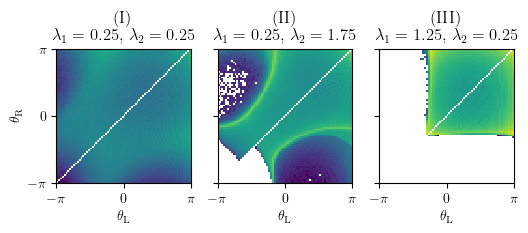

In [ ]:
plt.style.use(["./config/stylelib/thesis.mplstyle", "./config/stylelib/manuscript_grid_1x3.mplstyle"])

bins = 72
binning_range = [[-np.pi, np.pi], [-np.pi, np.pi]]
ticks = np.linspace(-np.pi, np.pi, 3)
tick_labels = [r"$-\pi$", r"$0$", r"$\pi$"]

fig, axs = plt.subplots(1, 3)
for i, (lmbd_1, lmbd_2) in enumerate(lambdas):
    
    hist_comp = np.zeros_like(hist_full[0])
    for j in np.arange(len(hist_comp)):
        for k in np.arange(j+1, len(hist_comp[j]), 1):
            hist_comp[k, j] = (hist_full[i][j, k] + hist_full[i][k, j]) / 2
            hist_comp[j, k] = (hist_gutz[i][j, k] + hist_gutz[i][k, j]) / 2

    axs[i].pcolormesh(edges_l, edges_r, hist_comp,
                      norm="log",
                      vmin=hist_gutz[i][np.nonzero(hist_gutz[i])].min(),
                      vmax=hist_gutz[i].max())

    # centers_l = (edges_l[1:] + edges_l[:-1]) / 2
    # centers_r = (edges_r[1:] + edges_r[:-1]) / 2   
    # axs[i].pcolormesh(centers_l, centers_r, hist_comp,
    #                   norm="log",
    #                   vmin=hist_gutz[np.nonzero(hist_gutz)].min(),
    #                   vmax=hist_gutz.max(),
    #                   shading='gouraud')

    axs[i].set_xticks(ticks)
    axs[i].set_xticklabels(tick_labels)
    axs[i].set_yticks(ticks)
    axs[i].set_yticklabels(tick_labels)
    axs[i].set_title(f'({(i+1) * "I"})\n'
                     rf"$\lambda_1 = {lmbd_1}$, $\lambda_2 = {lmbd_2}$")
    axs[i].set(xlabel=r"$\theta_\mathrm{L}$", ylabel=r"$\theta_\mathrm{R}$")
    axs[i].set(aspect='equal')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.savefig("plots/dimer/dimer-full-gutz-p-infty-mc.pdf")

## Marginal

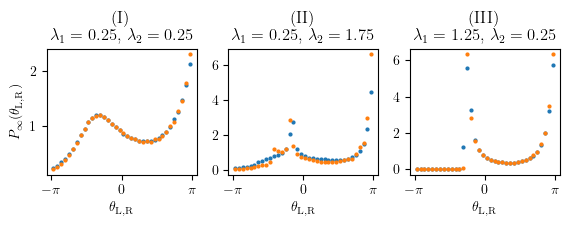

In [6]:
plt.style.use(["./config/stylelib/thesis.mplstyle", "./config/stylelib/manuscript_grid_1x3.mplstyle"])

bins = 36
binning_range = [-np.pi, np.pi]
ticks = np.linspace(-np.pi, np.pi, 3)
tick_labels = [r"$-\pi$", r"$0$", r"$\pi$"]

fig, axs = plt.subplots(1, 3)
for i, (lmbd_1, lmbd_2) in enumerate(lambdas):
    marg_full = np.sum(hist_full_lr[i], axis=0)
    marg_gutz = np.sum(hist_gutz_lr[i], axis=0)

    bin_centers_lr = (edges_l_lr[:-1] + edges_r_lr[1:]) / 2

    axs[i].plot(bin_centers_lr, marg_full,
                '.',
                label=r"Full MC")
    axs[i].plot(bin_centers_lr, marg_gutz,
                '.',
                label=r"Gutz MC")

    axs[i].set_xticks(ticks)
    axs[i].set_xticklabels(tick_labels)
    # axs[i].set_yticks(ticks)
    # axs[i].set_yticklabels(tick_labels)
    axs[i].set_title(f'({(i+1) * "I"})\n'
                     rf"$\lambda_1 = {lmbd_1}$, $\lambda_2 = {lmbd_2}$")
    axs[i].set(xlabel=r"$\theta_\mathrm{L, R}$", ylabel=r"$P_\infty(\theta_{\mathrm{L,R}})$")
    # axs[i].set(aspect='equal')
    # axs[i].legend()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.yaxis.set_tick_params(labelleft=True)
    
fig.tight_layout()
plt.savefig("plots/dimer/dimer-full-gutz-p-infty-marg-mc.pdf")

## Edge

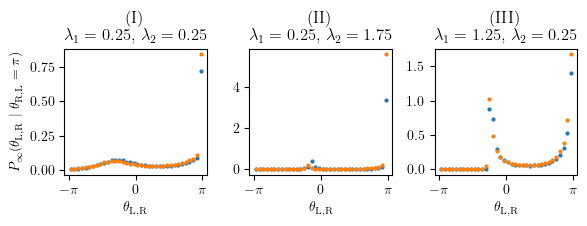

In [7]:
plt.style.use(["./config/stylelib/thesis.mplstyle", "./config/stylelib/manuscript_grid_1x3.mplstyle"])

bins = 36
binning_range = [[-np.pi, np.pi], [-np.pi, np.pi]]
ticks = np.linspace(-np.pi, np.pi, 3)
tick_labels = [r"$-\pi$", r"$0$", r"$\pi$"]

fig, axs = plt.subplots(1, 3)
for i, (lmbd_1, lmbd_2) in enumerate(lambdas):
    bin_centers_lr = (edges_l_lr[:-1] + edges_r_lr[1:]) / 2

    edge_full = (hist_full_lr[i][-1] + hist_full_lr[i][:, -1]) / 2
    edge_gutz = (hist_gutz_lr[i][-1] + hist_gutz_lr[i][:, -1]) / 2

    axs[i].plot(bin_centers_lr, edge_full,
                '.',
                label=r"Full MC")
    axs[i].plot(bin_centers_lr, edge_gutz,
                '.',
                label=r"Gutz MC")

    axs[i].set_xticks(ticks)
    axs[i].set_xticklabels(tick_labels)
    # axs[i].set_yticks(ticks)
    # axs[i].set_yticklabels(tick_labels)
    axs[i].set_title(f'({(i+1) * "I"})\n'
                     rf"$\lambda_1 = {lmbd_1}$, $\lambda_2 = {lmbd_2}$")
    axs[i].set(xlabel=r"$\theta_\mathrm{L, R}$", ylabel=r"$P_\infty(\theta_{\mathrm{L,R}} \mid \theta_{\mathrm{R,L}}=\pi)$")
    # axs[i].set(aspect='equal')
    # axs[i].legend()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.yaxis.set_tick_params(labelleft=True)
    
fig.tight_layout()
plt.savefig("plots/dimer/dimer-full-gutz-p-infty-edge-mc.pdf")

## Diagonal

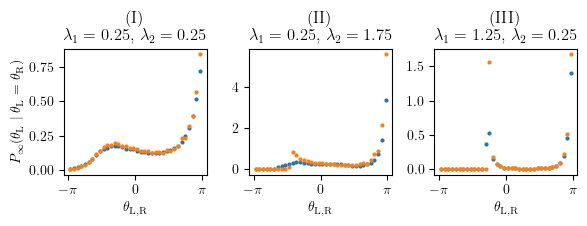

In [8]:
plt.style.use(["./config/stylelib/thesis.mplstyle", "./config/stylelib/manuscript_grid_1x3.mplstyle"])

bins = 36
binning_range = [[-np.pi, np.pi], [-np.pi, np.pi]]
ticks = np.linspace(-np.pi, np.pi, 3)
tick_labels = [r"$-\pi$", r"$0$", r"$\pi$"]

fig, axs = plt.subplots(1, 3)
for i, (lmbd_1, lmbd_2) in enumerate(lambdas):
    bin_centers_lr = (edges_l_lr[:-1] + edges_r_lr[1:]) / 2

    diag_full = np.diagonal(hist_full_lr[i])
    diag_gutz = np.diagonal(hist_gutz_lr[i])

    axs[i].plot(bin_centers_lr, diag_full,
                '.',
                label=r"Full MC")
    axs[i].plot(bin_centers_lr, diag_gutz,
                '.',
                label=r"Gutz MC")

    axs[i].set_xticks(ticks)
    axs[i].set_xticklabels(tick_labels)
    # axs[i].set_yticks(ticks)
    # axs[i].set_yticklabels(tick_labels)
    axs[i].set_title(f'({(i+1) * "I"})\n'
                     rf"$\lambda_1 = {lmbd_1}$, $\lambda_2 = {lmbd_2}$")
    axs[i].set(xlabel=r"$\theta_\mathrm{L, R}$", ylabel=r"$P_\infty(\theta_{\mathrm{L}} \mid \theta_{\mathrm{L}}=\theta_{\mathrm{R}})$")
    # axs[i].set(aspect='equal')
    # axs[i].legend()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.yaxis.set_tick_params(labelleft=True)
    
fig.tight_layout()
plt.savefig("plots/dimer/dimer-full-gutz-p-infty-diag-mc.pdf")